In [144]:
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd
from tsflex.processing import SeriesPipeline, SeriesProcessor
import os

In [ ]:
def filter(file_name):
    data = np.load(file_name)
    stages = np.load(file_name.replace('X', 'y'))

    filtered_data = data[stages != 0]
    filtered_stages = stages[stages != 0]

    start_index = np.argmax(filtered_stages != 1)
    end_index = len(filtered_stages) - np.argmax(filtered_stages[::-1] != 1)

    new_data = filtered_data[start_index:end_index]
    new_stages = filtered_stages[start_index:end_index]

    if new_data.ndim == 1:
        new_data = new_data.reshape(-1, 1)
        
    return new_data, new_stages


In [ ]:
def filter_concatenate(file_name):
    data = np.load(file_name)
    stages = np.load(file_name.replace('X', 'y'))

    mask = stages != 0
    filtered_data = data[mask]
    filtered_stages = stages[mask]

    start_index = np.argmax(filtered_stages != 1)
    end_index = len(filtered_stages) - np.argmax(filtered_stages[::-1] != 1)

    new_data = filtered_data[start_index:end_index]
    new_stages = filtered_stages[start_index:end_index]

    if new_data.ndim == 1:
        new_data = new_data.reshape(-1, 1)
    new_data = np.concatenate([new_data], axis=1)

    return new_data, new_stages

In [ ]:
def butter_bandpass_filter(sig, lowcut=0.4, highcut=30, fs=100, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

In [ ]:
def body_temp_filter(file_path, output_file_path, min_temp=36.1, max_temp=37.2, max_change_rate=0.001):
    data = np.load(file_path)
    filtered_data = []

    for temp_data in data[:, 5, :]:
        normal_temp_mask = (temp_data >= min_temp) & (temp_data <= max_temp)
        filtered_temp_data = temp_data[normal_temp_mask]

        change_rates = np.abs(np.diff(filtered_temp_data))
        stable_temp_data = filtered_temp_data[1:][change_rates <= max_change_rate]
        
        filtered_data.extend(stable_temp_data)

    np.save(output_file_path, filtered_data)
    
    time_array = np.arange(len(filtered_data)) / 100.0 
    plt.plot(time_array, filtered_data, label='Filtered Body Temperature')
    plt.title("Filtered Body Temperature Data Visualization")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()

In [ ]:
for i in range(24):
    for j in range(1, 3):
        file_name = f"training_new/p{i:02d}_n{j}_NEW_X.npy"
        output_name1 = f"p{i:02d}_n{j}_NEW_X_c.npy"
        output_name2 = f"p{i:02d}_n{j}_NEW_y_c.npy"
        try:
            new_data, new_stages = filter(file_name)
            filtered_data, _ = filter_concatenate(file_name)
            derivative = np.diff(filtered_data[0][3]) / np.diff(np.arange(len(filtered_data[0][3])))
            derivative_padded = np.pad(derivative, (0, 1), 'constant')
            
            if derivative_padded.shape[0] != new_data.shape[0]:
                derivative_reshaped = derivative_padded.reshape((new_data.shape[0]), -1)
                new_data[:, 3, :] = derivative_reshaped
            else:
                new_data[:, 3, :] = derivative_padded

            np.save(f"cleaned_data_new/{output_name1}", new_data)
            np.save(f"cleaned_data_new/{output_name2}", new_stages)
            print("Save Success!")

        except FileNotFoundError:
            print(f"No File Found for {file_name}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

(6, 2163000)
[ 1.10796798e-07  7.31989757e-07  2.19253013e-06  3.99881016e-06
  5.09100481e-06  5.10086000e-06  4.90511833e-06  4.45988333e-06
  7.23557805e-07 -5.61466448e-06]


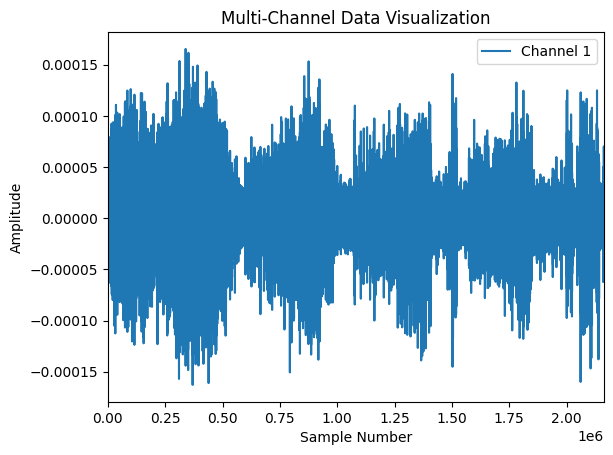

[ 5.05736199e-07  2.00275498e-06  2.19226680e-06 -1.18714867e-06
 -4.18708797e-06 -2.81334063e-06 -1.61687451e-07  1.05073238e-06
  2.96754079e-06  4.88976270e-06]


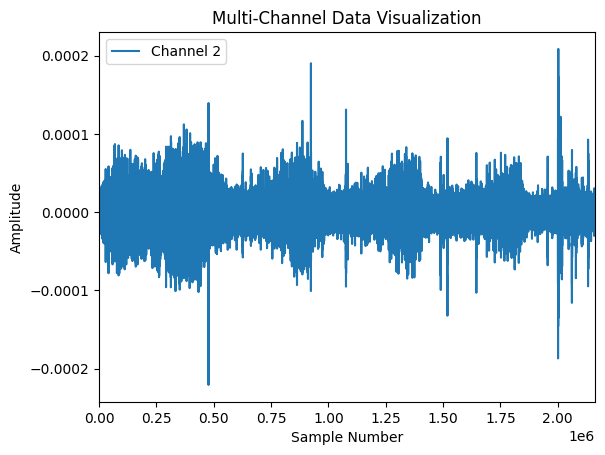

[ 1.54425546e-06  7.09394982e-06  1.25591295e-05  1.12059444e-05
  7.04697721e-06  4.54111669e-06  6.38342964e-07 -1.13239324e-06
  2.79356491e-06  7.79705636e-06]


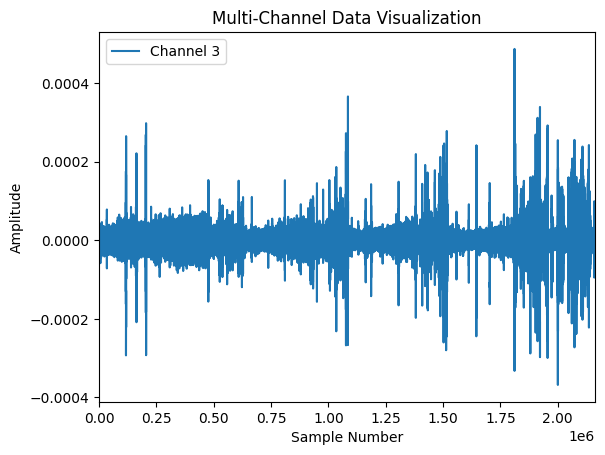

[ 0.247168    0.20376548  0.16021054  0.11652224  0.07271934  0.02882035
 -0.0151565  -0.05919325 -0.10327224 -0.14737607]


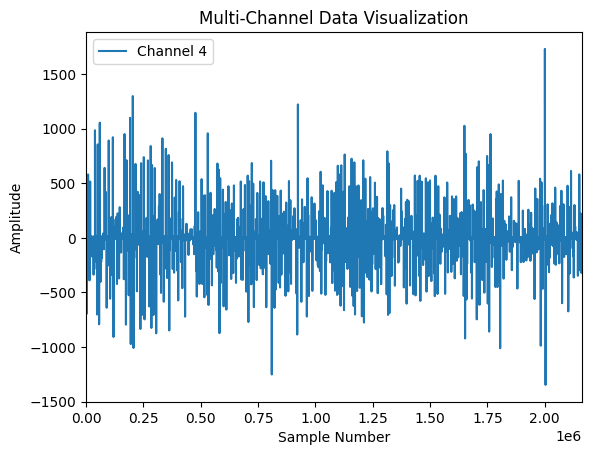

[3.34200000e-06 3.34171633e-06 3.34137542e-06 3.34097731e-06
 3.34052211e-06 3.34000994e-06 3.33944100e-06 3.33881551e-06
 3.33813376e-06 3.33739606e-06]


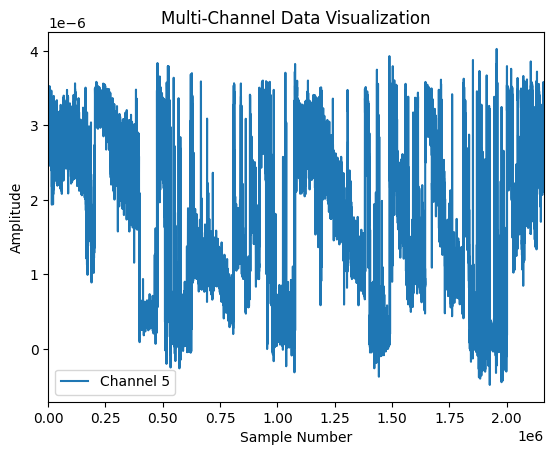

[36.88387097 36.88394193 36.88401599 36.884093   36.88417282 36.88425528
 36.88434022 36.88442749 36.88451692 36.88460834]


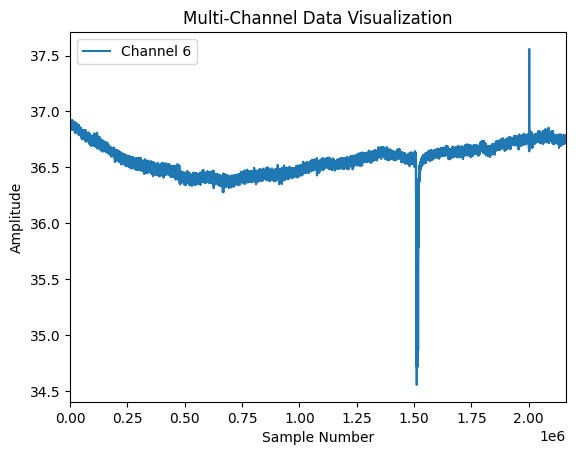

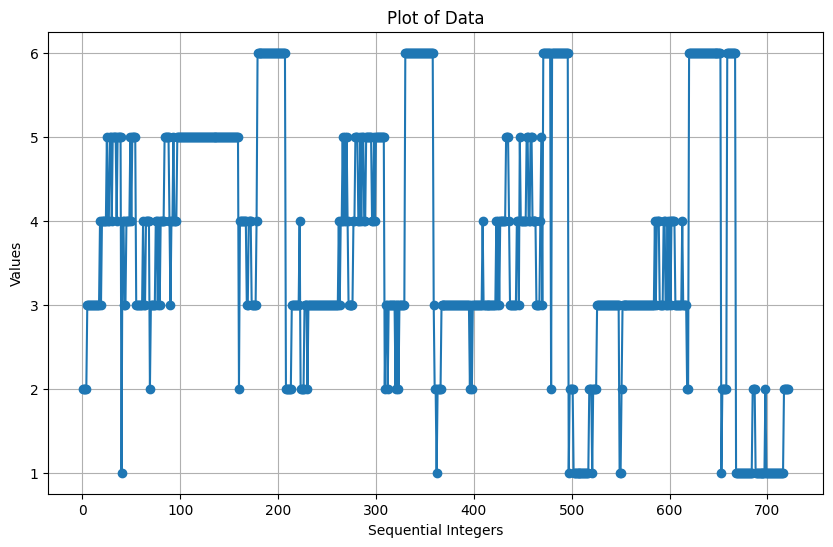

In [146]:
file_path = 'bassband_data_new/p00_n1_NEW_X_b.npy'
print_data, stages = filter_concatenate(file_path)
print(print_data.shape)
for i in range(print_data.shape[0]):
    x_values = np.arange(print_data.shape[1])
    plt.plot(print_data[i, :], label=f'Channel {i+1}')
    print(print_data[i][:10])
    plt.title("Multi-Channel Data Visualization")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.xlim(x_values[0], x_values[-1])
    plt.show()

x_axis = np.arange(1, len(stages) + 1)

if stages.ndim == 1:
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, stages, marker='o')  
    plt.title("Plot of Data")
    plt.xlabel("Sequential Integers")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show()

In [147]:
lowcut = 0.4
highcut = 30
fs = 100
order = 5

for i in range(25):  
    for j in range(1, 3): 
        file_name = f"cleaned_data_new/p{i:02d}_n{j}_NEW_X_c.npy"
        stage_name = file_name.replace('X_c.npy', 'y_c.npy')
        output_name1 = f"p{i:02d}_n{j}_NEW_X_b.npy"
        output_name2 = f"p{i:02d}_n{j}_NEW_y_b.npy"

        if os.path.exists(file_name):
            try:
                print(f"Processing file: {file_name}")
                data = np.load(file_name)
                print(f"Original data shape: {data.shape}")

                for column in range(3):
                    data[:, column, :] = np.apply_along_axis(
                        butter_bandpass_filter, 1, data[:, column, :], 
                        lowcut, highcut, fs, order
                    )

                np.save(f"bassband_data_new/{output_name1}", data)
                np.save(f"bassband_data_new/{output_name2}", np.load(stage_name))
                print("Data processing and saving completed successfully.")

            except Exception as e:
                print(f"Error processing {file_name}: {e}")
        else:
            print(f"File not found: {file_name}")

File found: cleaned_data_new/p00_n1_NEW_X_c.npy
(721, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p00_n2_NEW_X_c.npy
(1008, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p01_n1_NEW_X_c.npy
(983, 6, 3000)
Data saved successfully.
thank you sir
noo
File found: cleaned_data_new/p02_n1_NEW_X_c.npy
(905, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p02_n2_NEW_X_c.npy
(890, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p03_n1_NEW_X_c.npy
(832, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p03_n2_NEW_X_c.npy
(791, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p04_n1_NEW_X_c.npy
(1116, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p04_n2_NEW_X_c.npy
(1084, 6, 3000)
Data saved successfully.
thank you sir
File found: cleaned_data_new/p05_n1_NEW_X_c.npy
(552, 6, 3000)
Data saved s

In [ ]:
def compress_data(array, factor):
    if factor <= 0 or factor > array.shape[-1]:
        raise ValueError("Invalid compression factor.")
    return array.reshape(array.shape[0], array.shape[1], -1, factor).mean(axis=-1)

for i in range(24):  
    for j in range(1, 3): 
        file_name = f"bassband_data_new/p{i:02d}_n{j}_NEW_X_b.npy"
        stage_name = file_name.replace('X_b.npy', 'y_b.npy')
        output_name1 = f"p{i:02d}_n{j}_X_co.npy"
        output_name2 = f"p{i:02d}_n{j}_y_co.npy"

        if os.path.exists(file_name):
            print(f"Processing file: {file_name}")

            new_data = compress_data(np.load(file_name), 3)
            np.save(f"compressed_data/{output_name1}", new_data)
            np.save(f"compressed_data/{output_name2}", np.load(stage_name))
            print("Compression and saving successful.")
        else:
            print(f"File not found: {file_name}")


(6, 2709000)


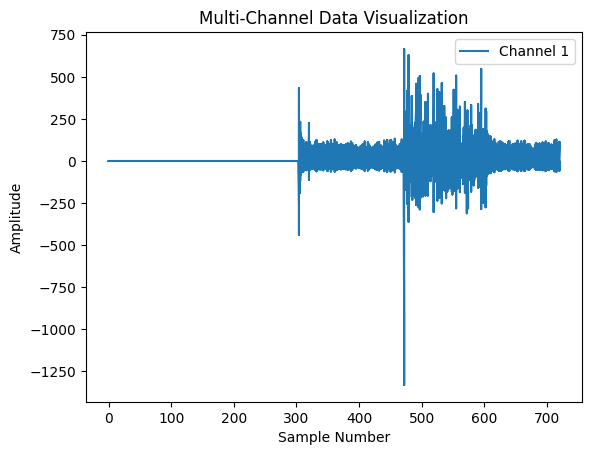

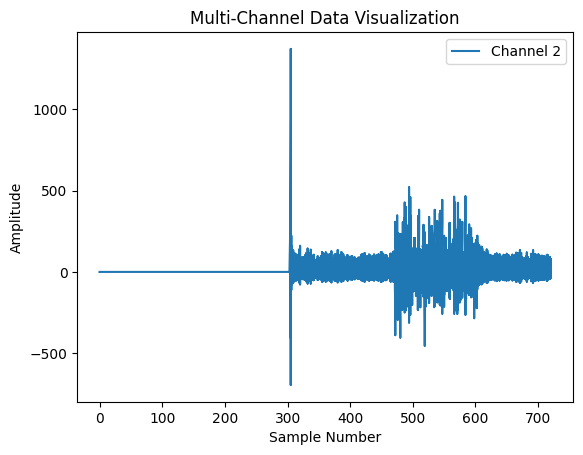

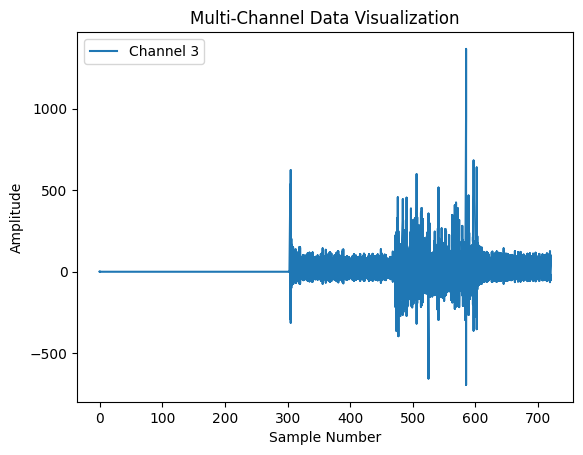

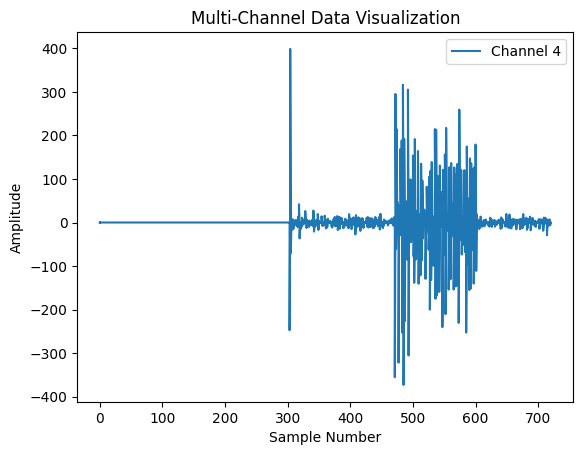

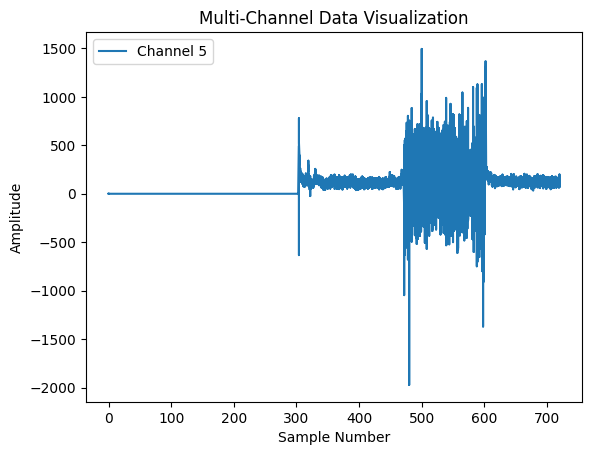

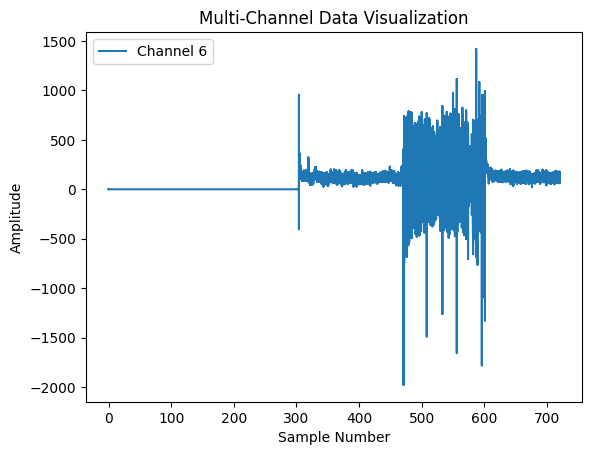

IndexError: index 6 is out of bounds for axis 1 with size 6

In [29]:
file_path = 'compressed_data/p00_n1_X_co.npy'
new_data = np.load(file_path)

plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(new_data.shape[0]):
    plt.plot(new_data[i, :], label=f'Channel {i+1}')

plt.title("Multi-Channel Data Visualization")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(2, new_data.shape[1] - 1)  # Adjust the x-axis limits
plt.show()

Processing file: training/p00_n1_y.npy
Compression and saving successful.
Processing file: training/p00_n2_y.npy
Compression and saving successful.
Processing file: training/p01_n1_y.npy
Compression and saving successful.
File not found: training/p01_n2_y.npy
Processing file: training/p02_n1_y.npy
Compression and saving successful.
Processing file: training/p02_n2_y.npy
Compression and saving successful.
Processing file: training/p03_n1_y.npy
Compression and saving successful.
Processing file: training/p03_n2_y.npy
Compression and saving successful.
Processing file: training/p04_n1_y.npy
Compression and saving successful.
Processing file: training/p04_n2_y.npy
Compression and saving successful.
Processing file: training/p05_n1_y.npy
Compression and saving successful.
Processing file: training/p05_n2_y.npy
Compression and saving successful.
Processing file: training/p06_n1_y.npy
Compression and saving successful.
Processing file: training/p06_n2_y.npy
Compression and saving successful.


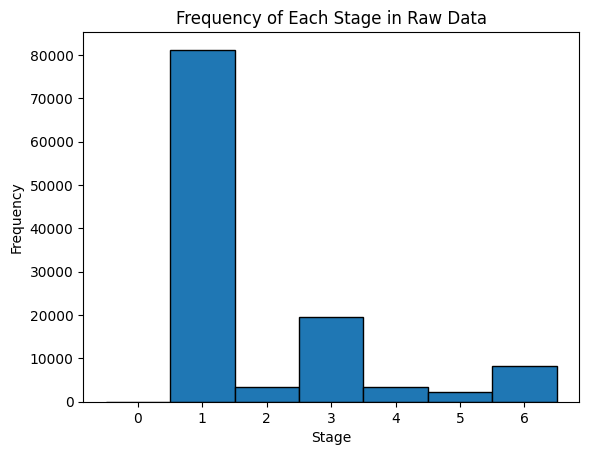

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
stages = np.array([])
for i in range(24):  
    for j in range(1, 3): 
        file_name = f"training/p{i:02d}_n{j}_y.npy"
        if os.path.exists(file_name):
            print(f"Processing file: {file_name}")
            stages = np.concatenate([stages, np.load(file_name)])

            print("Compression and saving successful.")
        else:
            print(f"File not found: {file_name}")
print(stages.shape)

plt.hist(stages, bins=np.arange(-0.5, 7.5, 1), edgecolor='black')
plt.xticks(np.arange(7))
plt.title('Frequency of Each Stage in Raw Data')
plt.xlabel('Stage')
plt.ylabel('Frequency')


plt.show()